## 0. Required Libraries

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import joblib
import json
import pandas as pd
import copy
import hashlib

import src.util as util

/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1. Load Configuration File

In [2]:
params = util.load_config()

## 2. Load Dataset

In [3]:
def load_train_feng(params: dict) -> pd.DataFrame:
    # Load train set
    x_train = util.pickle_load(params["train_feng_set_path"][0])
    y_train = util.pickle_load(params["train_feng_set_path"][1])

    return x_train, y_train

def load_valid_feng(params: dict) -> pd.DataFrame:
    # Load valid set
    x_valid = util.pickle_load(params["valid_feng_set_path"][0])
    y_valid = util.pickle_load(params["valid_feng_set_path"][1])

    return x_valid, y_valid

def load_test_feng(params: dict) -> pd.DataFrame:
    # Load test set
    x_test = util.pickle_load(params["test_feng_set_path"][0])
    y_test = util.pickle_load(params["test_feng_set_path"][1])

    return x_test, y_test

In [4]:
def load_dataset(params: dict) -> pd.DataFrame:
    # Debug message
    util.print_debug("Loading dataset.")

    # Load train set
    x_train, y_train = load_train_feng(params)

    # Load valid set
    x_valid, y_valid = load_valid_feng(params)

    # Load test set
    x_test, y_test = load_test_feng(params)

    # Debug message
    util.print_debug("Dataset loaded.")

    # Return the dataset
    return x_train, y_train, x_valid, y_valid, x_test, y_test

## 3. Create Training Log Template

In [5]:
def training_log_template() -> dict:
    # Debug message
    util.print_debug("Creating training log template.")
    
    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    # Debug message
    util.print_debug("Training log template created.")

    # Return training log template
    return logger

In [6]:
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log

## 4. Training and Evaluation

### 4.1. Create Model Object

In [7]:
def create_model_object(params: dict) -> list:
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects
    lgr = LogisticRegression()
    dct = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    knn = KNeighborsClassifier()
    xgb = XGBClassifier()

    # Create list of model
    list_of_model = [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""}
    ]

    # Debug message
    util.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

### 4.2. Training Baseline Model

In [8]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    x_train, y_train, \
    x_valid, y_valid, \
    x_test, y_test = load_dataset(params)

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid)
            performance = classification_report(y_valid, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}".format(configuration_model, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["macro avg"]["f1-score"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

In [9]:
list_of_trained_model, training_log = train_eval("Baseline", params)

2022-12-04 18:41:17.820462 Loading dataset.
2022-12-04 18:41:17.943131 Dataset loaded.
2022-12-04 18:41:17.943329 Creating training log template.
2022-12-04 18:41:17.943420 Training log template created.
2022-12-04 18:41:17.943517 Training model based on configuration data: Undersampling
2022-12-04 18:41:17.943599 Creating model objects.
2022-12-04 18:41:17.943787 Model objects created.
2022-12-04 18:41:17.943841 Training model: LogisticRegression


/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2022-12-04 18:41:18.937424 Evalutaing model: LogisticRegression
2022-12-04 18:41:18.983581 Logging: LogisticRegression
2022-12-04 18:41:18.984141 Model LogisticRegression has been trained for configuration data Undersampling.
2022-12-04 18:41:18.985155 Training model: DecisionTreeClassifier
2022-12-04 18:41:19.157901 Evalutaing model: DecisionTreeClassifier
2022-12-04 18:41:19.210609 Logging: DecisionTreeClassifier
2022-12-04 18:41:19.212546 Model DecisionTreeClassifier has been trained for configuration data Undersampling.
2022-12-04 18:41:19.212846 Training model: RandomForestClassifier
2022-12-04 18:41:24.227114 Evalutaing model: RandomForestClassifier
2022-12-04 18:41:24.846447 Logging: RandomForestClassifier
2022-12-04 18:41:25.026671 Model RandomForestClassifier has been trained for configuration data Undersampling.
2022-12-04 18:41:25.026849 Training model: KNeighborsClassifier
2022-12-04 18:41:25.041910 Evalutaing model: KNeighborsClassifier
2022-12-04 18:41:57.242015 Logging: 

/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2022-12-04 18:42:03.355181 Evalutaing model: XGBClassifier
2022-12-04 18:42:03.455823 Logging: XGBClassifier
2022-12-04 18:42:03.553861 Model XGBClassifier has been trained for configuration data Undersampling.
2022-12-04 18:42:04.012044 Training model based on configuration data: Oversampling
2022-12-04 18:42:04.012496 Creating model objects.
2022-12-04 18:42:04.012966 Model objects created.
2022-12-04 18:42:04.051422 Training model: LogisticRegression


/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2022-12-04 18:42:05.718265 Evalutaing model: LogisticRegression
2022-12-04 18:42:05.763827 Logging: LogisticRegression
2022-12-04 18:42:05.764271 Model LogisticRegression has been trained for configuration data Oversampling.
2022-12-04 18:42:05.764360 Training model: DecisionTreeClassifier
2022-12-04 18:42:06.423564 Evalutaing model: DecisionTreeClassifier
2022-12-04 18:42:06.473158 Logging: DecisionTreeClassifier
2022-12-04 18:42:06.476167 Model DecisionTreeClassifier has been trained for configuration data Oversampling.
2022-12-04 18:42:06.476310 Training model: RandomForestClassifier
2022-12-04 18:42:24.948625 Evalutaing model: RandomForestClassifier
2022-12-04 18:42:25.632340 Logging: RandomForestClassifier
2022-12-04 18:42:25.970139 Model RandomForestClassifier has been trained for configuration data Oversampling.
2022-12-04 18:42:25.970349 Training model: KNeighborsClassifier
2022-12-04 18:42:26.007453 Evalutaing model: KNeighborsClassifier
2022-12-04 18:44:10.129143 Logging: KNe

/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2022-12-04 18:44:27.463857 Evalutaing model: XGBClassifier
2022-12-04 18:44:27.559975 Logging: XGBClassifier
2022-12-04 18:44:27.662082 Model XGBClassifier has been trained for configuration data Oversampling.
2022-12-04 18:44:28.410008 Training model based on configuration data: SMOTE
2022-12-04 18:44:28.410199 Creating model objects.
2022-12-04 18:44:28.410349 Model objects created.
2022-12-04 18:44:28.479093 Training model: LogisticRegression


/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2022-12-04 18:44:30.133650 Evalutaing model: LogisticRegression
2022-12-04 18:44:30.179137 Logging: LogisticRegression
2022-12-04 18:44:30.179529 Model LogisticRegression has been trained for configuration data SMOTE.
2022-12-04 18:44:30.179603 Training model: DecisionTreeClassifier
2022-12-04 18:44:30.807656 Evalutaing model: DecisionTreeClassifier
2022-12-04 18:44:30.852499 Logging: DecisionTreeClassifier
2022-12-04 18:44:30.855321 Model DecisionTreeClassifier has been trained for configuration data SMOTE.
2022-12-04 18:44:30.855465 Training model: RandomForestClassifier
2022-12-04 18:44:49.846467 Evalutaing model: RandomForestClassifier
2022-12-04 18:44:50.569542 Logging: RandomForestClassifier
2022-12-04 18:44:50.892236 Model RandomForestClassifier has been trained for configuration data SMOTE.
2022-12-04 18:44:50.892445 Training model: KNeighborsClassifier
2022-12-04 18:44:50.930809 Evalutaing model: KNeighborsClassifier
2022-12-04 18:46:38.472233 Logging: KNeighborsClassifier
202

/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2022-12-04 18:46:59.183886 Evalutaing model: XGBClassifier
2022-12-04 18:46:59.280943 Logging: XGBClassifier
2022-12-04 18:46:59.398480 Model XGBClassifier has been trained for configuration data SMOTE.
2022-12-04 18:47:00.186671 All combination models and configuration data has been trained.


### 4.3. Choose Best Performance Baseline Model

In [10]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    util.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("Loading validation data.")
        x_valid, y_valid = load_valid_feng(params)
        
        # Debug message
        util.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(x_valid.columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")

            # Debug message
            util.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(x_valid)

            # Re-asses prediction result
            eval_res = classification_report(y_valid, y_pred, output_dict = True)

            # Debug message
            util.print_debug("Assessing complete.")

            # Debug message
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["f1_score_avg"] = eval_res["macro avg"]["f1-score"]

            # Debug message
            util.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    util.print_debug("Sorting training log by f1 macro avg and training time.")

    # Sort training log by f1 score macro avg and trining time
    best_model_log = training_log.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    # Debug message
    util.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen production model
    util.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log
    

In [11]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2022-12-04 18:49:34.399020 Choosing model by metrics score.
2022-12-04 18:49:34.399228 Converting training log type of data from dict to dataframe.
2022-12-04 18:49:34.412179 Trying to load previous production model.
2022-12-04 18:49:36.421775 Previous production model loaded.
2022-12-04 18:49:36.421961 Loading validation data.
2022-12-04 18:49:36.451626 Checking compatibilty previous production model's input with current train data's features.
2022-12-04 18:49:36.524132 Different features between production model with current dataset is detected, ignoring production dataset.
2022-12-04 18:49:36.524475 Sorting training log by f1 macro avg and training time.
2022-12-04 18:49:36.532408 Searching model data based on sorted training log.
2022-12-04 18:49:37.126682 Model chosen.


## 5. Hyperparameter Tuning

In [12]:
def create_dist_params(model_name: str) -> dict:
    # Define models paramteres
    dist_params_xgb = {
        "n_estimators" : [50, 100, 200, 300, 400, 500]
    }
    dist_params_dct = {
        "algorithm" : ["gini", "entropy", "log_loss"],
        "min_sample_split" : [1, 2, 4, 6, 10, 15, 20, 25],
        "min_sample_leaf" : [1, 2, 4, 6, 10, 15, 20, 25]
    }
    dist_params_knn = {
        "creterion" : ["ball_tree", "kd_tree", "brute"],
        "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
        "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    }
    dist_params_lgr = {
        "penalty" : ["l1", "l2", "elasticnet", "none"],
        "C" : [0.01, 0.05, 0.10, 0.15, 0.20, 0.30, 0.60, 0.90, 1],
        "solver" : ["saga"],
        "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    }
    dist_params_rfc = {
        "criterion" : ["gini", "entropy", "log_loss"],
        "n_estimators" : [50, 100, 200, 300, 400, 500],
        "min_samples_split" : [1, 2, 4, 6, 10, 15, 20, 25],
        "min_samples_leaf" : [1, 2, 4, 6, 10, 15, 20, 25]
    }

    # Make all models parameters in to one
    dist_params = {
        "XGBClassifier": dist_params_xgb,
        "DecisionTreeClassifier": dist_params_dct,
        "KNeighborsClassifier": dist_params_knn,
        "LogisticRegression": dist_params_lgr,
        "RandomForestClassifier": dist_params_rfc
    }

    # Return distribution of model parameters
    return dist_params[model_name]

In [13]:
def hyper_params_tuning(model: dict) -> list:
    # Create copy of current best baseline model
    model = copy.deepcopy(model)

    # Create model's parameter distribution
    dist_params = create_dist_params(model["model_data"]["model_name"])

    # Create model object
    model_rsc = RandomizedSearchCV(model["model_data"]["model_object"], dist_params, n_jobs = -1)
    model_data = {
        "model_name": model["model_data"]["model_name"],
        "model_object": model_rsc,
        "model_uid": ""
    }
    
    # Return model object
    return [model_data]

In [14]:
list_of_trained_model, training_log = train_eval("Hyperparams_Tuning", params, hyper_params_tuning(model))

2022-12-04 18:49:45.757486 Loading dataset.
2022-12-04 18:49:46.189495 Dataset loaded.
2022-12-04 18:49:46.189696 Creating training log template.
2022-12-04 18:49:46.189792 Training log template created.
2022-12-04 18:49:46.189882 Training model based on configuration data: Undersampling
2022-12-04 18:49:46.580992 Training model: RandomForestClassifier
2022-12-04 18:52:21.430295 Evalutaing model: RandomForestClassifier
2022-12-04 18:52:22.314195 Logging: RandomForestClassifier
2022-12-04 18:52:22.759070 Model RandomForestClassifier has been trained for configuration data Undersampling.
2022-12-04 18:52:23.191032 Training model based on configuration data: Oversampling
2022-12-04 18:52:24.012525 Training model: RandomForestClassifier


/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_on

2022-12-04 19:02:49.736305 Evalutaing model: RandomForestClassifier
2022-12-04 19:02:51.393093 Logging: RandomForestClassifier
2022-12-04 19:02:53.371871 Model RandomForestClassifier has been trained for configuration data Oversampling.
2022-12-04 19:02:55.636169 Training model based on configuration data: SMOTE
2022-12-04 19:02:56.382133 Training model: RandomForestClassifier


/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Users/macintoshhd/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_on

2022-12-04 19:11:06.945326 Evalutaing model: RandomForestClassifier
2022-12-04 19:11:07.190484 Logging: RandomForestClassifier
2022-12-04 19:11:07.552916 Model RandomForestClassifier has been trained for configuration data SMOTE.
2022-12-04 19:11:07.910701 All combination models and configuration data has been trained.


In [15]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2022-12-04 19:21:28.110662 Choosing model by metrics score.
2022-12-04 19:21:28.110953 Converting training log type of data from dict to dataframe.
2022-12-04 19:21:28.115647 Trying to load previous production model.
2022-12-04 19:21:28.990278 Previous production model loaded.
2022-12-04 19:21:28.990475 Loading validation data.
2022-12-04 19:21:29.020333 Checking compatibilty previous production model's input with current train data's features.
2022-12-04 19:21:29.020558 Features compatible.
2022-12-04 19:21:29.020623 Reassesing previous model performance using current validation data.
2022-12-04 19:21:29.677917 Assessing complete.
2022-12-04 19:21:29.678086 Storing new metrics data to previous model structure.
2022-12-04 19:21:29.678141 Adding previous model data to current training log and list of model
2022-12-04 19:21:30.027298 Sorting training log by f1 macro avg and training time.
2022-12-04 19:21:30.031320 Searching model data based on sorted training log.
2022-12-04 19:21:30.65

## 6. Take a Look at Confusion Matrix

In [16]:
x_valid, y_valid = load_valid_feng(params)

In [17]:
y_pred = model["model_data"]["model_object"].predict(x_valid)

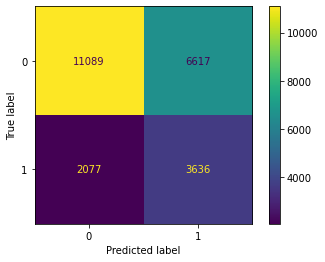

In [18]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)

In [19]:
TP = 3636
TN = 11089
FP = 6617
FN = 2077

ACC = (TN+TP)/(TN+FP+FN+TP)
P = TP/(TP+FP)
R = TP/(TP+FN)
F1 = 2*(P*R/(P+R))

In [20]:
print(ACC)
print(P)
print(R)
print(F1)

0.6287629702378411
0.3546279137813323
0.636443199719937
0.455467869222097
